# Numerically Controlled Oscillator

In this tutorial we will demonstrate how to use the numerically controlled oscillator (NCO) during an experiment by [Changing the modulation frequency](#Frequency-sweeps), e.g. for rapid spectroscopy measurements

We will show this by using a [QRM](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/qrm.html) and directly connecting outputs
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on
the outputs and simultaneously acquire the resulting waveforms on the inputs.

Whilst this tutorial is for the baseband modules, a similar procedure for spectroscopy with RF modules can be found in the [RF Control](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/rf/rf_control.html) tutorial.

## Getting Started

### How the NCO works

#### Modulation

The NCO modulates any AWG output at a certain frequency, such that we only need to store the envelope of any waveform to create a wave with the correct frequency and phase. To enable IQ up- and downconversion to RF frequencies, the device will generate a phase shifted signal on both signal paths.

If modulation is enabled, the value of the NCO ($f$) will be multiplied with the awg ($z(t)$) output and forwarded to path 0/1 as follows:

\begin{equation*}
z_{\text{mod}, 0/1} (t) = z(t) \cdot e^{\pm i 2 \pi f t}
\end{equation*}

These two outputs can then be used within a QRM-RF module or by an external IQ mixer to generate RF pulses. Each path, 0/1, will have two components (real and imaginary) referred to as I and Q. However, the NCO can also be operated in real mode which will create a direct modulated output.

#### Demodulation
Usually, we are interested in the envelope of the acquired signal instead of the oscillating values, in particular when integrating. Therefore, the NCO can also be used to demodulate the signal before integration.
If demodulation is enabled, the signal is again multiplied with the NCO, this time with a prefactor $\sqrt{2}$. Thus, if we modulate and demodulate the same signal, we obtain the original awg output:

\begin{equation*}
\text{path}_{0, \text{in}} = \sqrt{2}(\cos(\omega t)\text{in}_0-\sin(\omega t)\text{in}_1)
=  \cos(\omega t)\cos(\omega t)\text{awg}_0+\sin(\omega t)\sin(\omega t)\text{awg}_0 = \text{awg}_0
\tag{3}
\end{equation*}

\begin{equation*}
\text{path}_{1, \text{in}} = \sqrt{2}(\cos(\omega t)\text{in}_1+\sin(\omega t)\text{in}_0)
=  \cos(\omega t)\cos(\omega t)\text{awg}_1+\sin(\omega t)\sin(\omega t)\text{awg}_1 = \text{awg}_1
\tag{4}
\end{equation*}



### Setup

First, we are going to import the required packages and connect to the instrument.

In [1]:

from __future__ import annotations

import json
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
from qcodes.instrument import find_or_create_instrument
from scipy.signal import spectrogram, welch

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from numpy.typing import NDArray

    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

Frequency sweeps  <a id='freq_sw'></a>
------------------------------
One of the most common experiments is to test the frequency response of the system, e.g. to find the resonance frequencies of a qubit or a resonator. For the purpose of this tutorial, we will sweep the full frequency range supported by the QRM. To improve accuracy we can use the maximum integration time and multiple averages. This does not change the overall measurement time much, as most of it is used for the setup.

In [9]:
start_freq = -500e6
stop_freq = 500e6

n_averages = 10
MAXIMUM_SCOPE_ACQUISITION_LENGTH = 16384

In this tutorial, we will analyze the raw data measured by the scope acquisition of the QRM. For this we will define a simple helper function using [scipy.signal.spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) and [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). The spectrogram shows the frequency spectrum of the QRM output as a function of time, to visualize the frequency sweeps we are doing. Welch's method is used to compute the input power as a function of frequency (power spectral density). This way we obtain the response of the system to find features of interest, e.g. a resonance.

In [10]:
# Power as function of frequency and time by chunking the data
def plot_spectrogram(time_series: np.ndarray) -> None:
    f_sample = 1e9  # All devices have 1 GSPS sample rate
    fig, ax = plt.subplots(1, 2)

    f, t, Sxx = spectrogram(time_series, f_sample, return_onesided=False, detrend=False)

    idx = np.argsort(f)
    f = f[idx] / 1e6
    Sxx = Sxx[idx]

    spec = ax[0].pcolormesh(t, f, Sxx, shading="auto", cmap="YlOrRd")
    cb = fig.colorbar(spec)
    cb.set_label("Power Spectral Density [V$^2$/Hz]")
    ax[0].set_ylabel("Frequency [MHz]")
    ax[0].set_xlabel("Time [s]")

    f, Pxx = welch(time_series, f_sample, return_onesided=False, detrend=False)

    idx = np.argsort(f)
    f = f[idx] / 1e6
    Pxx = Pxx[idx]

    ax[1].semilogy(f, Pxx)
    ax[1].set_xlabel("Frequency [MHz]")
    ax[1].set_ylabel("Power Spectral Density [V$^2$/Hz]")
    fig.tight_layout()
    plt.show()

And two more helper functions for plotting the amplitude of an array of I, Q values and a scope acquisition:

In [11]:
def plot_amplitude(x: NDArray, I_data: NDArray, Q_data: NDArray) -> None:
    amplitude = np.abs(I_data + 1j * Q_data)

    plt.plot(x / 1e6, amplitude)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Integration [V]")
    plt.show()


def plot_scope(trace: NDArray, t_min: int, t_max: int) -> None:
    x = np.arange(t_min, t_max)
    plt.plot(x, np.real(trace[t_min:t_max]))
    plt.plot(x, np.imag(trace[t_min:t_max]))
    plt.ylabel("Scope [V]")
    plt.xlabel("Time [ns]")
    plt.show()

### Setting up the QRM
We set up a modulated DC offset:

In [12]:
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Configure channel map
readout_module.sequencer0.connect_sequencer("io0_1")

# Set DC Offset
readout_module.sequencer0.offset_awg_path0(1)
readout_module.sequencer0.offset_awg_path1(1)

# Enable modulation and demodulation. Note that the scope is not demodulated
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)

# Enable hardware averaging for the scope
readout_module.scope_acq_avg_mode_en_path0(True)
readout_module.scope_acq_avg_mode_en_path1(True)

readout_module.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)

### NCO sweep controlled by the host computer
As a baseline, we will run a simple frequency sweep controlled by the host computer using QCoDeS. We do this by setting a DC offset and modulating it with the NCO. This is quite slow, so we will only measure 200 steps to keep the measurement time reasonable.

In [13]:
n_steps = 200

step_freq = (stop_freq - start_freq) / n_steps
print(f"Step size {step_freq/1e6} MHz")

nco_sweep_range = np.arange(start_freq, stop_freq, step_freq)

Step size 5.0 MHz


Now we set up a simple program that acquires data and averages. The frequency will be set later with the QCoDeS interface.

Note: While most operations and parameters are executed/updated on a 1 ns timegrid, the instructions that operate on the sequencer’s NCOs (e.g. set_freq, reset_ph, set_ph, set_ph_delta) are updated on a 4 ns timegrid. The minimum time between frequency changes is 8 ns.

In [14]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

# Sequence program.
slow_sweep = f"""
    move    {n_averages}, R0            # Average iterator.

avg_loop:
    reset_ph
    upd_param 200
    acquire 0, 0, {MAXIMUM_SCOPE_ACQUISITION_LENGTH}

    loop    R0, @avg_loop

    stop
"""

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": slow_sweep,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Next, we prepare the QRM for the measurement:

In [15]:
readout_module.sequencer0.sequence("sequence.json")

Now we can run the frequency sweep. This is simply a loop where we set the frequency with QCoDeS and then run the program defined above. We measure the run time using the `%%time` Jupyter magic command.

In [16]:
%%time
data = []
for nco_val in nco_sweep_range:
    # Set the frequency
    readout_module.sequencer0.nco_freq(nco_val)

    # Run the program
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the sequencer to stop with a timeout period of one minute.
    readout_module.get_acquisition_state(0, 1)

    # Move acquisition data from temporary memory to acquisition list.
    readout_module.store_scope_acquisition(0, "acq")

    # Get acquisition list from instrument.
    data.append(readout_module.get_acquisitions(0)["acq"])

    # Clear acquisition data so we do not average the results from different frequencies
    readout_module.sequencer0.delete_acquisition_data("acq")

c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox

CPU times: total: 312 ms
Wall time: 14 s


Plotting the acquired integration data, we can see the frequency behavior of the QRM.

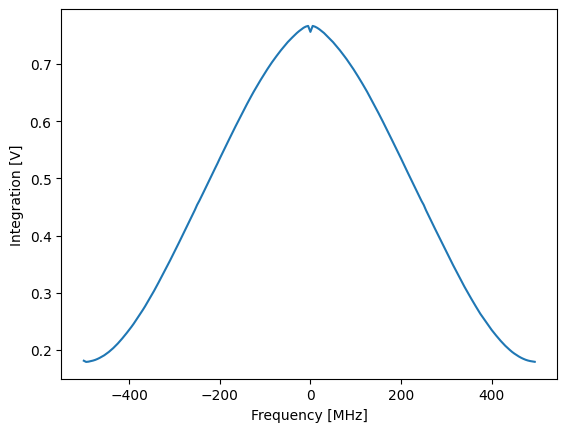

In [17]:
I_data = (
    np.asarray([d["acquisition"]["bins"]["integration"]["path0"][0] for d in data])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
Q_data = (
    np.asarray([d["acquisition"]["bins"]["integration"]["path1"][0] for d in data])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
plot_amplitude(nco_sweep_range, I_data, Q_data)

We can see that the output amplitude decreases with frequency, this is expected due to the analog filters. We can also analyze the accumulated scope data with a spectrogram. This takes a few seconds, as there are 16384 data points per frequency step. Note that the time axis of the spectrogram refers to measurement time (16.4us * 200 steps $\approx$ 3.3ms) and not the wall clock time, which is significantly longer.

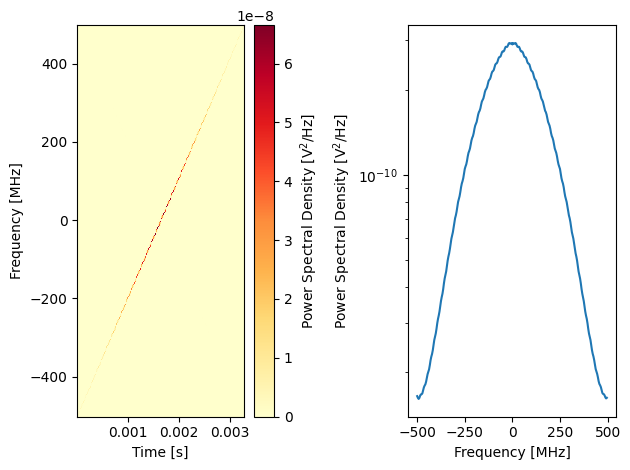

In [18]:
data_scope = (
    np.asarray([d["acquisition"]["scope"]["path0"]["data"] for d in data]).flatten()
    + 1j * np.asarray([d["acquisition"]["scope"]["path1"]["data"] for d in data]).flatten()
)

plot_spectrogram(data_scope)

### Spectroscopy using Q1ASM
Now we will run the same spectroscopy experiment using Q1ASM to change the NCO frequency in real time. First, we set up the QRM for continuous wave output and binned acquisition with many bins. This is significantly faster than using QCoDeS. The maximum number of points that can be measured this way is 131072 per sequencer. This corresponds to the number of bins available for acquisition per sequencer.

The sequencer program can fundamentally only support integer values. However, the NCO has a frequency resolution of 0.25 Hz and supports $10^9$ phase values. Therefore, frequencies in the sequencer program must be given as integer multiple of $1/4$ Hz, and phases as integer multiple of $360/10^9$ degree.

In [19]:
n_steps = 200

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

200 steps with step size 5.0 MHz


In [20]:
acquisitions = {"acq": {"num_bins": n_steps, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move    0, R1          # step counter
"""

# To get a negative starting frequency, we subtract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

spectroscopy = (
    setup
    + f"""
    reset_ph
    set_freq        R0
    upd_param       200

nco_set:
    set_freq        R0                           # Set the frequency
    add             R0, {nco_int_step_freq}, R0  # Update the frequency register
    upd_param       200                          # Wait for time of flight
    acquire         0, R1, {MAXIMUM_SCOPE_ACQUISITION_LENGTH}
    add             R1, 1, R1
    nop
    jlt             R1, {n_steps}, @nco_set      # Loop over all frequencies

    loop            R2, @avg_loop

    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": spectroscopy,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

Now we prepare the QRM for measurement.

In [21]:
readout_module.sequencer0.sequence("sequence.json")

In [22]:
%%time
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

print("Status:")
print(readout_module.get_sequencer_state(0))

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

data = readout_module.get_acquisitions(0)["acq"]

Status:
Status: RUNNING, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
CPU times: total: 62.5 ms
Wall time: 141 ms


Note that the same measurement as before is now two orders of magnitude faster. If we plot the integrated data, we get the same results as before.

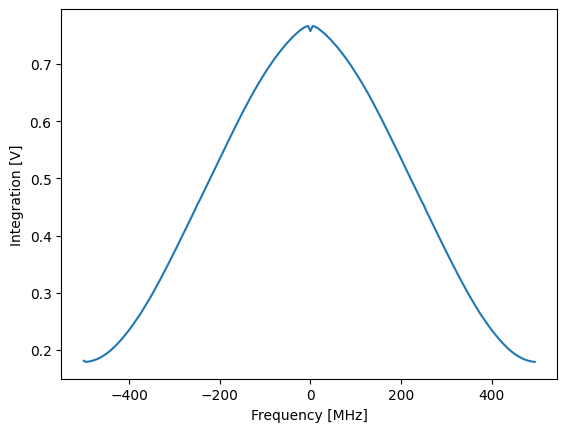

In [23]:
# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = (np.arange(n_steps) * nco_int_step_freq + nco_int_start_freq) / 4.0

I_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path0"])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
Q_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path1"])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
plot_amplitude(nco_sweep_range, I_data, Q_data)

#### NCO input delay compensation
By default, the input and output of the QRM are multiplied with the same NCO value. As the output path has a time of flight of about 146 ns between the NCO and playback, this means that there is a short time window after frequency/phase updates where demodulation is updated, but playback is still using the old value. There is also always a (fixed) relative phase between playback and demodulation. We can showcase this by using a similar program as before, but with less points, so that the frequency steps are more clearly visible.

In [24]:
n_steps = 20
n_averages = 1000

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

20 steps with step size 50.0 MHz


To make the effect of NCO delay compensation more apparent, we modify the spectroscopy program for short integration time and acquire immediately after the frequency update, without waiting for time of flight. This means that the output at the new frequency only arrives at the input AFTER integration in the current loop iteration has finished. Without further modifications of the program this leads to an off-by-one error. Therefore, we increase the frequency as the first step in the loop.

In [25]:
acquisitions = {"acq": {"num_bins": n_steps, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move    0, R1          # step counter
"""

# To get a negative starting frequency, we subtract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

spectroscopy = (
    setup
    + f"""
    reset_ph
    set_freq        R0
    upd_param       200

nco_set:
    # Due to time of flight, the new frequency will only arrive at the input AFTER integration is done
    # Therefore, we already increase the frequency before the first measurement.
    add             R0, {nco_int_step_freq}, R0
    nop
    set_freq        R0

    # we removed upd_param, so that acquisition starts the moment the frequency is updated
    acquire         0, R1, 1200                  # Update the NCO and immediately acquire
    add             R1, 1, R1
    nop
    jlt             R1, {n_steps}, @nco_set      # Loop over all frequencies

    loop            R2, @avg_loop

    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": spectroscopy,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

As a baseline, we will do a measurement with delay compensation disabled.

In [26]:
readout_module.sequencer0.sequence("sequence.json")
readout_module.sequencer0.integration_length_acq(140)
readout_module.sequencer0.nco_prop_delay_comp_en(False)

Status:
Status: RUNNING, Flags: ACQ_BINNING_DONE


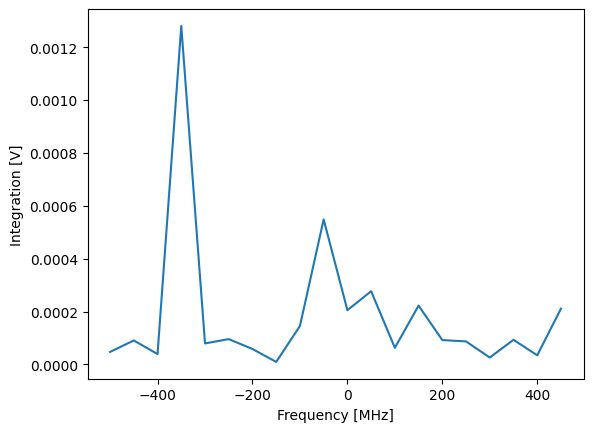

In [27]:
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

print("Status:")
print(readout_module.get_sequencer_state(0))

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, timeout=1)

data = readout_module.get_acquisitions(0)["acq"]
I_data = np.asarray(data["acquisition"]["bins"]["integration"]["path0"]) / 140
Q_data = np.asarray(data["acquisition"]["bins"]["integration"]["path1"]) / 140
plot_amplitude(nco_sweep_range, I_data, Q_data)

Even though we only measured a small number of points, we can see that this is not compatible with the previous spectroscopy measurements. What happened is that `set_freq` updates the NCO frequency immediately. However, there is a time of flight of about 146 ns between the NCO and the output of the device. Thus, the signal will be demodulated at $f_0 + 100$ MHz immediately after `set_freq`, but the incoming signal is still modulated at $f_0$ for another 146 ns - longer than the integration time chosen above. The integrated signal will therefore be approximately zero.

Now we run the same experiment again, with delay compensation enabled.

In [28]:
readout_module.sequencer0.sequence("sequence.json")
readout_module.sequencer0.nco_prop_delay_comp_en(True)

This ensures that, for demodulation, the NCO only updates after the time of flight, i.e. that frequency and phase of modulation and demodulation always match.

Status:
Status: RUNNING, Flags: ACQ_BINNING_DONE


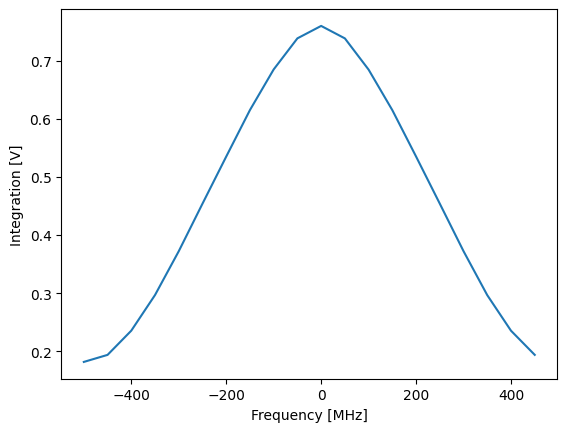

In [29]:
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

print("Status:")
print(readout_module.get_sequencer_state(0))

# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_state(0, timeout=1)

data = readout_module.get_acquisitions(0)["acq"]
I_data = np.asarray(data["acquisition"]["bins"]["integration"]["path0"]) / 140
Q_data = np.asarray(data["acquisition"]["bins"]["integration"]["path1"]) / 140
amplitude = np.abs(I_data + 1j * Q_data)

plot_amplitude(nco_sweep_range, I_data, Q_data)

We can see that modulation and demodulation frequency now match, producing similar results as the spectroscopy measurements before.

## Stop

Finally, let's stop the playback and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [30]:
# Stop both sequencers.
readout_module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(readout_module.get_sequencer_state(0))
print(readout_module.get_sequencer_state(1))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE
Status: STOPPED, Flags: FORCED_STOP

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	True 
scope_acq_avg_mode_en_path1   :	True 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	True 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	140 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	True 
nco_freq                         :	4.95e+08 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	True (n

cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE
